In [1]:
#@title Imports
from IPython.display import clear_output
from tqdm.notebook import tqdm
import time
import numpy as np
import math
from collections import namedtuple
import random
from tqdm.notebook import tqdm
import torch
import torch.nn as nn                               
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim   
import torch.nn.functional as F
from matplotlib import pyplot as plt
from math import pi as pi
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

In [2]:
#@title Choose device
device = 'cuda'

In [3]:
#@title Cartpole Environment
class Cartpole:
    def __init__(self, init_state, action_interval):
        self.m1 = 0.5
        self.m2 = 0.5
        self.l = 0.6
        self.b = 0.1
        self.g = 9.82
        self.dt = 0.01
        self.Tinv = torch.tensor([[1., self.l, 0.],
                                  [self.l, self.l**2, 0.], 
                                  [0., 0., self.l**2]])
        self.jtarget = torch.tensor([0., 0., 1.])
        self.T = action_interval
        self.action_time = int(self.T/self.dt)
        self.init_state = init_state.clone().detach()
        self.current_state = init_state.clone().detach()

        self.action_space = torch.linspace(-10, 10, 11)
        self.n_actions = len(self.action_space)

    def reset(self, ):
        self.current_state = self.init_state.clone().detach()


    def euler_step(self, action):
        x = self.current_state
        x[2] = -x[2]+pi;
        x = (x + self.dt
                * (torch.tensor([
                                 x[1], 
                                 (2*self.m2*self.l*x[3]**2*torch.sin(x[2]) + 3*self.m2*self.g*torch.sin(x[2])*torch.cos(x[2]) 
                                 + 4*action - 4*self.b*x[1])/(4*(self.m1+self.m2) - 3*self.m2*torch.cos(x[2])**2), 
                                 x[3], 
                                 (-3*self.m2*self.l*x[3]**2*torch.sin(x[2])*torch.cos(x[2]) - 6*(self.m1+self.m2)*self.g*torch.sin(x[2]) 
                                 - 6*(action-self.b*x[1])*torch.cos(x[2]))/(4*self.l*(self.m1+self.m2) - 3*self.m2*self.l*torch.cos(x[2])**2)
                                 ])
                    )
             )
                
        # Check boundaries
        # pos
        if x[0] > 6:
            x[0] = 6
            x[1] = -0.5*x[1]
        elif x[0] < -6:
            x[0] = -6
            x[1] = -0.5*x[1]
        
        # pos_dot
        if x[1] > 10:
            x[1] = 10
        elif x[1] < -10:
            x[1] = -10
        
        # theta
        x[2] = -(x[2]-pi)
        if x[2] > pi:
            x[2] = -(2*pi - x[2])
        elif x[2] < -pi:
            x[2] = (2*pi + x[2])
        
        # theta_dot
        if x[3] > 10:
            x[3] = 10
        elif x[3] < -10:
            x[3] = -10

        self.current_state = x

    def step(self, action_idx):
        action = self.action_space[action_idx]
        for _ in range(self.action_time):
            self.euler_step(action)
        x = self.current_state
        j = torch.tensor([x[0], torch.sin(x[2]), torch.cos(x[2])])
        jj = j - self.jtarget
        reward = torch.tensor([-(1-torch.exp(-0.5*(jj @ self.Tinv @ jj.T )))])
        return self.current_state, reward

def test():
    x = torch.zeros(T_test,4)
    r = torch.zeros(T_test,1)
    env.reset()
    for t in range(T_test):
        action_idx = policy_net(env.current_state.to(device).unsqueeze(0)).max(1)[1].item()
        x[t], r[t] = env.step(action_idx)
    return sum(r), x

In [4]:
#@title Memory
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
#@title Select action
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].unsqueeze(0)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


In [6]:
#@title Update network
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return 
    # Sample mini-batch from memory buffer
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    next_states_batch = torch.cat(batch.next_state)
    
    # Compute the expected Q values
    next_state_values = target_net(next_states_batch).max(1)[0].detach().unsqueeze(1)
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute MSE loss
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    loss = F.mse_loss(state_action_values, expected_state_action_values)

    # Optimize DQN
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

In [7]:
#@title Model class
class DQN(nn.Module):
    def __init__(self, input_dim, outputs):
        super(DQN, self).__init__()
        self.nunits = 1000
        self.h = nn.ReLU()
        self.fc1 = nn.Linear(input_dim, self.nunits)
        self.fc2 = nn.Linear(self.nunits, self.nunits)
        self.fc3 = nn.Linear(self.nunits, self.nunits)
        self.fc4 = nn.Linear(self.nunits, self.nunits)
        self.head = nn.Linear(self.nunits, outputs)

    def forward(self, x):
        x = self.h(self.fc1(x))
        x = self.h(self.fc2(x))
        x = self.h(self.fc3(x))
        x = self.h(self.fc4(x))
        return self.head(x)


In [8]:
#@title Initialize
env = Cartpole(torch.tensor([0., 0., pi, 0.]), 0.1)
memory = ReplayMemory(2000)
# Get number of actions from env action space
n_actions = env.n_actions
steps_done = 0
policy_net = DQN(4, n_actions).to(device)
target_net = DQN(4, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
acc_rewards = []
optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)
acc_reward = []

In [9]:
#@title Training
BATCH_SIZE = 128
GAMMA = 0.9
EPS_START = 0.99
EPS_END = 0.01
EPS_DECAY = 10000
optimizer.param_groups[0]['lr'] = 1e-4
num_episodes = 400
episode_len = 50
TARGET_UPDATE = 100
TEST_UPDATE = 1000
T_test = 50
for i_episode in tqdm(range(num_episodes)):
    loss = 0
    # Initialize the environment and state
    env.reset()
    state = env.current_state.unsqueeze(0).to(device)
    for t in range(episode_len):
        # Select and perform an action
        action = select_action(state)
        next_state, reward  = env.step(action.item())
        next_state = next_state.unsqueeze(0).to(device)
        reward = reward.unsqueeze(0).to(device)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization
        l = optimize_model()
        if l:
            loss += l
        # Update the target network
        if steps_done % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
        if steps_done % TEST_UPDATE == 0 :
            r , _ = test()
            acc_reward.append(r)

    print('Episode {}, Steps {}, loss {:.2e}'.format(i_episode, steps_done, loss/episode_len))
print('Complete')
acc_rewards.append(acc_reward)
clear_output(wait=True)

Episode 0, Steps 50, loss 0.00e+00
Episode 1, Steps 100, loss 0.00e+00
Episode 2, Steps 150, loss 5.16e-02
Episode 3, Steps 200, loss 1.07e-02
Episode 4, Steps 250, loss 3.60e-02
Episode 5, Steps 300, loss 8.98e-03
Episode 6, Steps 350, loss 2.74e-02
Episode 7, Steps 400, loss 9.92e-03
Episode 8, Steps 450, loss 2.99e-02
Episode 9, Steps 500, loss 1.17e-02
Episode 10, Steps 550, loss 3.09e-02
Episode 11, Steps 600, loss 1.41e-02
Episode 12, Steps 650, loss 3.05e-02
Episode 13, Steps 700, loss 1.31e-02
Episode 14, Steps 750, loss 2.99e-02
Episode 15, Steps 800, loss 1.39e-02
Episode 16, Steps 850, loss 3.04e-02
Episode 17, Steps 900, loss 1.04e-02
Episode 18, Steps 950, loss 2.35e-02
Episode 19, Steps 1000, loss 1.30e-02
Episode 20, Steps 1050, loss 2.33e-02
Episode 21, Steps 1100, loss 1.32e-02
Episode 22, Steps 1150, loss 2.78e-02
Episode 23, Steps 1200, loss 1.62e-02
Episode 24, Steps 1250, loss 2.51e-02
Episode 25, Steps 1300, loss 1.22e-02
Episode 26, Steps 1350, loss 2.52e-02
Epis

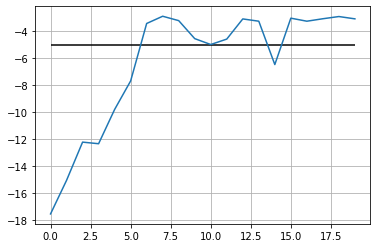

In [13]:
#@title Plot accumulated reward
plt.plot(acc_reward)
plt.hlines(-5,0,len(acc_reward)-1)
plt.grid()
plt.show()

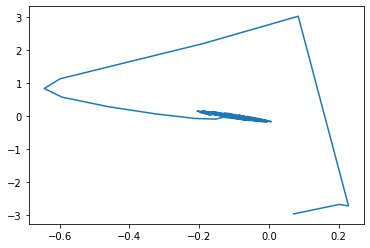

In [11]:
#@title Simulate Trajectory
T_test=100
_, x = test()
plt.plot(x[:,0],x[:,2])
plt.show()

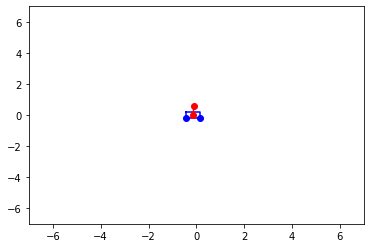

In [12]:
#@title Simulate Cartpole
trajec = x
i = 0;
while i < T_test:
    angle = trajec[i, 2]
    car_pos = torch.tensor([trajec[i, 0], 0])
    pend_pos = car_pos+torch.tensor([0.6*torch.cos(angle+pi/2), 0.6*torch.sin(angle+pi/2)])
    plt.plot([car_pos[0]-0.3, car_pos[0]+0.3, car_pos[0]+0.3, car_pos[0]-0.3, car_pos[0]-0.3],
        [car_pos[1]+0.2, car_pos[1]+0.2, car_pos[1]-0.2, car_pos[1]-0.2, car_pos[1]+0.2],'b')
    plt.plot([car_pos[0]+0.3, car_pos[0]-0.3],[car_pos[1]-0.2, car_pos[1]-0.2], 'ob')
    plt.plot([car_pos[0], pend_pos[0]], [car_pos[1], pend_pos[1]], '-or')
    plt.xlim([-7, 7])
    plt.ylim([-7, 7])
    plt.show()
    
    clear_output(wait=True)
    time.sleep(0.09)  
    i += 1